# Predicting Employee Productivity

We plan on utilizing this dataset, transforming the productivity range (0-1) into different classes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('..\Datasets\garments_worker_productivity.csv') 
df.head(10)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
5,1/1/2015,Quarter1,sweing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125
6,1/1/2015,Quarter1,finishing,Thursday,2,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.755167
7,1/1/2015,Quarter1,sweing,Thursday,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,0.753683
8,1/1/2015,Quarter1,sweing,Thursday,2,0.75,19.87,733.0,6000,34,0.0,0,0,55.0,0.753098
9,1/1/2015,Quarter1,sweing,Thursday,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,0.750428


## Exploratory Data Analysis

Let's get a better grasp of what exactly the dataset entails. As per the official documentation, the columns of the dataset:
- `date`: date in MM-DD-YYYY
- `quarter` : a portion of the month — month was divided into four quarters
- `department`: associated department with the instance
- `day`: day of the week
- `team`: associated team number with the instance
- `targeted_productivity`: targeted productivity set by the authority for each team for each day
- `smv`: standard minute value — the allocated time for a task
- `wip`: work in progress — includes the number of unfinished items for products
- `over_time`: represents the amount of overtime by each team in minutes
- `incentive`: represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action
- `idle_time`: the duration of time when the production was interrupted due to several reasons
- `idle_men`: the number of workers who were idle due to production interruption
- `no_of_style_change`: number of changes in the style of a particular product
- `no_of_workers`: number of workers on each team
- `actual_productivity`: the actual % of productivity that was delivered by the workers — it ranges from 0 to 1.

In [32]:
#shape of the dataset
print(f'Rows in dataset:',df.shape[0])
print(f'Columns in dataset:',df.shape[1])

Rows in dataset: 1197
Columns in dataset: 15


In [5]:
#column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

Looks like there's over 500 null values in column `wip`.

In [34]:
#basic statistics of dataset
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


#### `date`

In [99]:
df['date'].value_counts(sort=False)

date
1/1/2015     19
1/3/2015     21
1/4/2015     21
1/5/2015     22
1/6/2015     21
1/7/2015     22
1/8/2015     22
1/10/2015    22
1/11/2015    23
1/12/2015    23
1/13/2015    22
1/14/2015    21
1/15/2015    19
1/17/2015    21
1/18/2015    19
1/19/2015    19
1/20/2015    15
1/21/2015    19
1/22/2015    22
1/24/2015    23
1/25/2015    21
1/26/2015    19
1/27/2015    21
1/28/2015    21
1/29/2015    20
1/31/2015    24
2/1/2015     19
2/2/2015     19
2/3/2015     19
2/4/2015     19
2/5/2015     18
2/7/2015     19
2/8/2015     19
2/9/2015     18
2/10/2015    19
2/11/2015    19
2/12/2015    19
2/14/2015    17
2/15/2015    19
2/16/2015    18
2/17/2015    20
2/18/2015    21
2/19/2015    20
2/22/2015    20
2/23/2015    19
2/24/2015    19
2/25/2015    21
2/26/2015    21
2/28/2015    21
3/1/2015     20
3/2/2015     20
3/3/2015     22
3/4/2015     21
3/5/2015     19
3/7/2015     19
3/8/2015     22
3/9/2015     22
3/10/2015    23
3/11/2015    24
Name: count, dtype: int64

In [101]:
df['date'].tail()

1192    3/11/2015
1193    3/11/2015
1194    3/11/2015
1195    3/11/2015
1196    3/11/2015
Name: date, dtype: object

The values in `date` are all in 2015 and span the first day of year up through March 11.

#### Categorical 

c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cisco\anaconda3\envs\env_3_10_8\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

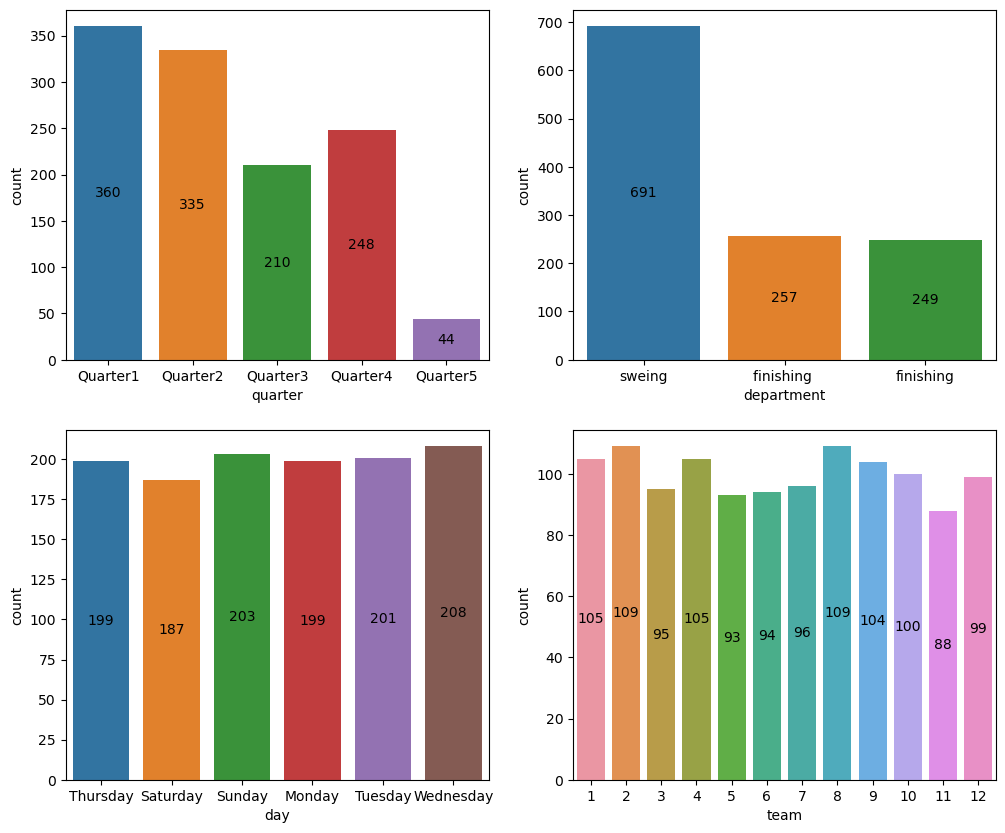

In [110]:
cat_cols = ['quarter', 'department', 'day',	'team']

fig = plt.figure(figsize=(12,10))

for idx, col in enumerate(cat_cols):
    ax = plt.subplot(2, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    #add data label to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

There looks to be some misspellings in `department`.

In [106]:
# identifying department values
df['department'].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

There's really only two departments in the dataset: sewing and finishing. Sewing has been misspelled as `sweing` and `finishing` has been split in two thanks to an extra space character.

#### Numeric Columns


In [111]:
num_cols = ['targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

In [75]:
# comparing wip with incentive
df[df['incentive'] == 0]['wip'].value_counts(dropna=False)

wip
NaN       496
834.0       2
708.0       2
726.0       1
1116.0      1
         ... 
1167.0      1
1608.0      1
557.0       1
326.0       1
1161.0      1
Name: count, Length: 107, dtype: int64

Of the instances where `incentive` is `0`, `wip` is `NaN`, or, otherwise also 0. There might end up being a strong correlation between the two if we can adjust the `NaN` values. 

In [50]:
df['no_of_style_change'].value_counts()

no_of_style_change
0    1050
1     114
2      33
Name: count, dtype: int64

In [53]:
df['actual_productivity'].value_counts(bins=12, sort=False)

(0.232, 0.308]     30
(0.308, 0.381]     43
(0.381, 0.455]     39
(0.455, 0.529]     50
(0.529, 0.603]     81
(0.603, 0.677]     99
(0.677, 0.751]    235
(0.751, 0.825]    276
(0.825, 0.899]    136
(0.899, 0.973]    145
(0.973, 1.047]     55
(1.047, 1.12]       8
Name: count, dtype: int64

#### `day`

These values are simply the day of the week.

In [102]:
df['day'].value_counts()

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64

We can see here that work took place from Saturday to Thursday.

 #### Exploratory Data Analysis - Summary
 Many of the columns in the dataset were imported into our workspace appropriately, but some others might need more attention and even some clean-up.
 - `date`
    - Could change its current `object` (string) data type to `datetime`
- `quarter`
    - Could be changed from `object` (string) to an integer
- `department`
    - typos present for both departments (sewing and finishing)
- `day`
     - could benefit from change of `object` (string) to an integer 
- `team`
    - 1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 - `wip`
     - has over 500 null values
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
- `no_of_workers`
    - There's isn't much of a reason why this column's data type should be `float64`
      actual_productivity    1197 non-null   float64

In [35]:
df[['idle_time', 'idle_men']].value_counts()

idle_time  idle_men
0.0        0           1179
2.0        10             2
3.5        15             2
8.0        35             2
3.5        20             1
4.0        20             1
           40             1
4.5        25             1
           30             1
5.0        20             1
           30             1
6.5        30             1
90.0       10             1
150.0      15             1
270.0      45             1
300.0      37             1
dtype: int64

In [36]:
df[df['idle_time'] == 270.0]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
650,2/7/2015,Quarter1,sweing,Saturday,7,0.7,24.26,658.0,6960,0,270.0,45,0,58.0,0.66227


In [37]:
df['idle_time'].value_counts()

0.0      1179
3.5         3
2.0         2
5.0         2
8.0         2
4.5         2
4.0         2
90.0        1
150.0       1
270.0       1
300.0       1
6.5         1
Name: idle_time, dtype: int64

In [38]:
df['idle_men'].value_counts()

0     1179
10       3
15       3
30       3
20       3
35       2
45       1
37       1
25       1
40       1
Name: idle_men, dtype: int64

In [39]:
df.corr()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
team,1.000000,0.030274,-0.110011,-0.033474,-0.096737,-0.007674,0.003796,0.026974,-0.011194,-0.075113,-0.148753
targeted_productivity,0.030274,1.000000,-0.069489,0.062054,-0.088557,0.032768,-0.056181,-0.053818,-0.209294,-0.084288,0.421594
smv,-0.110011,-0.069489,1.000000,-0.037837,0.674887,0.032629,0.056863,0.105901,0.315388,0.912176,-0.122089
wip,-0.033474,0.062054,-0.037837,1.000000,0.022302,0.167210,-0.026299,-0.048718,-0.072357,0.030383,0.131147
over_time,-0.096737,-0.088557,0.674887,0.022302,1.000000,-0.004793,0.031038,-0.017913,0.059790,0.734164,-0.054206
incentive,-0.007674,0.032768,0.032629,0.167210,-0.004793,1.000000,-0.012024,-0.021140,-0.026607,0.049222,0.076538
idle_time,0.003796,-0.056181,0.056863,-0.026299,0.031038,-0.012024,1.000000,0.559146,-0.011598,0.058049,-0.080851
idle_men,0.026974,-0.053818,0.105901,-0.048718,-0.017913,-0.021140,0.559146,1.000000,0.133632,0.106946,-0.181734
no_of_style_change,-0.011194,-0.209294,0.315388,-0.072357,0.059790,-0.026607,-0.011598,0.133632,1.000000,0.327787,-0.207366
no_of_workers,-0.075113,-0.084288,0.912176,0.030383,0.734164,0.049222,0.058049,0.106946,0.327787,1.000000,-0.057991


<AxesSubplot:>

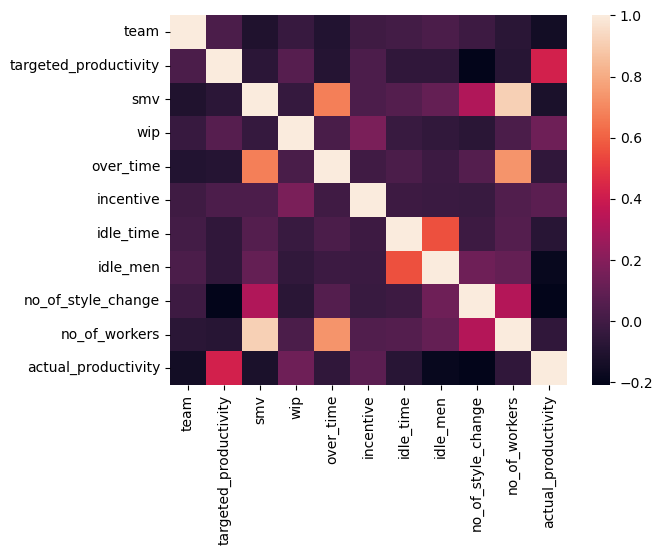

In [44]:
sns.heatmap(df.corr())

## Cleaning Up the Dataset

1. `date`
2. `department`
